# **Road Lane Lines detection in images and video sequences** 
***

## Overview
In this project I have implemented a simple road lines detection algorithm with the following properties
- Can detect road lines in a single still image or a list of images.
- Can detect road lines in a given video sequence and optionally to show the output and/or write out a video file with an overlay with the detected lines. 

In the case of the video sequence, lines detected in the past frames are being used to localize lines in current video frame. This significantly improves robustness of the system in situations where the road marking is not clearly recognizable in the current video frame.


## Description of the algorithm

The implemented algorithm is very simple and performs the detection in the following sequence:

- A road lines projection mask is calculated from a hardcoded dimensions, initially determined by visual inspection of the images at hand. The dimensions are derived from the video/image frame size.


<figure>
 <img src="masked_image_screenshot_27.12.2016.png" width="380" alt="" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;">Blue polygons show the road lines projection mask</p> 
 </figcaption>
</figure>


- White and yellow areas are thresholded in the source image. This is done in two main steps, detection of yellow lines and then the white ones. To detect the yellow lines the image is transformed to HSV color space and then, according to hardcoded thresholds, only yellow regions are selected. Morphological open operation is then used to clean up the binary image. White regions are thresholded by the standard opencv threshold function with hardcoded level. The yellow and white masks are then added together.

- The thresholded image is then masked with the road line projection mask to obtain blobs mainly relevant to the left and right lines.


<figure>
 <img src="masked_lines_screenshot_27.12.2016.png" width="380" alt="" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;">Blobs obtained after yellow/white image thresholding and masking with the road lines projection mask</p> 
 </figcaption>
</figure>



- To localize the road lines the right and left segments are processed independently. The line is then fitted through the blobs with a simple least square method. To do that the binary image is first converted to a vector of 2D points, each corresponding to a pixel with value one. This is clearly not the most robust or computationally efficient technique, however for the given scenarios performs extremely well. In order to cope with situations where the road marking is not clearly visible or temporarily obscured in shadows or missing, the estimated line is weighted by a prior line detected in a past image. This is done by rendering the prior line to the binary image before collecting the 2D points for the line fitting. The weight with which we want the prior line to guide the new estimation is set by the line thickness during the rendering. In the case of clearly visible road lines their binary blobs will result in significantly more 2D points than the ones provided by the rendered prior line (depending on the prior line weight - the line thickness) thus the estimated line will predominantly fit through the current blobs only. In other cases where only sparse or no road line blobs are detected the prior line will provide the only 2D points for the line fitting, thus the newly estimated line will mainly copy the prior one.
 

This algorithm is extremely simple and relatively robust for the given scenarios. The code performing the road lines detection is only about 200 python lines. While this algorithm performs very well for the provided images, it is very important to note that there are many hardcoded parameters that were tuned just for the images/videos at hand, which most certainly resulted in implementation over fitted for the given samples. In order to produce an algorithm generally applicable to wider range or scenarios the code would need to be modified.


In [7]:
import sys
import time
import numpy as np
import os
import cv2

class RoadLinesDetector:

    def __init__(self):
        self.line_color = (0,0,255)
        self.line_thickness = 3
        self.blend_weight = 0.6
        self.show_video = False
        self.debug = False

        self.left_projection_polygon = []
        self.right_projection_polygon = []
        self.left_line_estimate = None
        self.right_line_estimate = None
        self.current_frame = None

        self.wnd_name_img_out = 'detected lines'
        self.wnd_name_img_in = 'input image'


    def init_gui(self):
        cv2.namedWindow(self.wnd_name_img_in, cv2.WINDOW_NORMAL)
        cv2.resizeWindow(self.wnd_name_img_in, 1200, 800)
        cv2.moveWindow(self.wnd_name_img_in, 0,0)

        cv2.namedWindow(self.wnd_name_img_out, cv2.WINDOW_NORMAL)
        cv2.resizeWindow(self.wnd_name_img_out, 1200, 800)
        cv2.moveWindow(self.wnd_name_img_out, 1350,0)


    def reset(self):
        self.left_line_estimate = None
        self.right_line_estimate = None
        return


    def init_detector(self, video_frame):
        img_height = video_frame.shape[0]
        img_width = video_frame.shape[1]
        self.left_projection_polygon, self.right_projection_polygon = self.get_road_projection_mask(img_width, img_height)
        self.left_line_estimate = None
        self.right_line_estimate = None


    def frame_geometry_changed(self, video_frame):
        return (self.current_frame is None or
                video_frame.shape[0] != self.current_frame.shape[0] or
                video_frame.shape[1] != self.current_frame.shape[1])


    def get_road_projection_mask(self, img_width, img_height):
        vertices_left = np.array([[
            (img_width*0.09, img_height),
            (img_width*0.42, img_height*0.62),
            (img_width*0.51, img_height*0.62),
            (img_width*0.34, img_height),
        ]], dtype=np.int32)

        vertices_right = np.array([[
            (img_width*0.79, img_height),
            (img_width*0.53, img_height*0.62),
            (img_width*0.63, img_height*0.62),
            (img_width*1.0, img_height),
        ]], dtype=np.int32)

        return vertices_left, vertices_right


    def threshold_frame(self, video_frame):

        self.current_frame = video_frame

        # Threshold yellow areas
        kernel_size = 5
        blur_clr = cv2.GaussianBlur(video_frame, (kernel_size, kernel_size), 0)
        hsv = cv2.cvtColor(blur_clr, cv2.COLOR_BGR2HSV)

        # Define upper and lower hue level for HSV thresholding
        lower_clr = (20, 100, 100)
        upper_clr = (30, 255, 255)

        mask_yellow = cv2.inRange(hsv, lower_clr, upper_clr)

        kernel = np.ones((7, 3), np.uint8)
        mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_OPEN, kernel)


        # Threshold white areas
        gray = cv2.cvtColor(video_frame, cv2.COLOR_RGB2GRAY)

        kernel_size = 3
        blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 2)

        ret, mask_white = cv2.threshold(blur_gray, 200, 255, cv2.THRESH_BINARY)

        # Combine yellow and white masks
        mask = cv2.bitwise_or(mask_white, mask_yellow)

        if self.debug:
            cv2.imshow('mask_yellow', mask_yellow)
            cv2.imshow('mask_white', mask_white)
            cv2.imshow('mask_lines', mask)

        return mask



    # Creates a gray scale mask image from a given polygon vertices
    def mask_image(self, image, vertices):
        mask = np.zeros_like(image)
        ignore_mask_color = (255)
        cv2.fillPoly(mask, vertices, ignore_mask_color)
        masked_image = cv2.bitwise_and(image, mask)
        return masked_image


    def get_mask_image(self, vertices):
        clr_mask = np.zeros_like(self.current_frame)
        cv2.fillPoly(clr_mask, vertices, (255, 0, 0))
        return clr_mask

    # Returns endpoints for a line section begining at the bottom of the image
    # and extending to the image height * 0.61
    # Input is line direction vector (vx,vy) and point on the line x,y
    def extend_line(self, vx, vy, x, y, img_height):
        m = vy / vx
        b = int((-x * m) + y)

        y_offset = int(img_height*0.61)

        yo = img_height
        xo = (yo-b)/m
        xt = (y_offset-b)/m

        return [(xo, yo), (xt, y_offset)]


    # Fits a line through blobs in the input binary image. 
    # Least square error is used to fit the line through the blobs
    # Pixels with values 1 represent points to fit the line through.
    # In order to weight the estimated line to a know prior we render the prior line
    # to the input binary image first. This results in adding points lying on the prior line to the
    # 2D point set generated from the blobs in the input image. The weight the prior line  
    # influences the estimated line is controlled by the number of points generated for the prior 
    # line. This is achieved but rendering the prior line to the source image with different thickness
    
    def fit_line(self, image, prior_line):

        prior_line_weight = 1
        if prior_line  is not None:
            cv2.line(image,  prior_line[0],  prior_line[1], 255, prior_line_weight, 4)

        locations = cv2.findNonZero(image)
        [vx, vy, x, y] = cv2.fitLine(locations, cv2.DIST_L2, 0, 0.01, 0.01)

        return self.extend_line(vx, vy, x, y, image.shape[0])


    def render_lines(self, image, left_line, right_line, fps=None):
        lines_image = np.copy(image)
        cv2.line(lines_image, left_line[0], left_line[1], self.line_color, self.line_thickness, cv2.LINE_AA)
        cv2.line(lines_image, right_line[0], right_line[1], self.line_color, self.line_thickness, cv2.LINE_AA)
        image_out = cv2.addWeighted(image, 1 - self.blend_weight, lines_image, self.blend_weight, 0)

        if fps is not None:
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image_out, "fps: %d" %(int(fps)), (10, 20), font, 0.7, (0, 255, 0), 2, cv2.LINE_AA)

        return image_out




    def detect(self, video_frame):

        if video_frame is None:
            return None

        if self.frame_geometry_changed(video_frame):
            self.init_detector(video_frame)

        binary_img = self.threshold_frame(video_frame)

        masked_left = self.mask_image(binary_img, self.left_projection_polygon)
        masked_right = self.mask_image(binary_img, self.right_projection_polygon)

        self.left_line_estimate = self.fit_line(masked_left, self.left_line_estimate)
        self.right_line_estimate = self.fit_line(masked_right, self.right_line_estimate)

        if self.debug:
            cv2.imshow('masked_edges_left', masked_left)
            cv2.imshow('masked_edges_right', masked_right)

            mask_images_left = self.get_mask_image(self.left_projection_polygon)
            mask_images_right = self.get_mask_image(self.right_projection_polygon)
            masked_image = cv2.bitwise_or(mask_images_left, mask_images_right)

            debug_image = cv2.addWeighted(image_out, 0.8, masked_image, 1, 0)
            cv2.imshow('masked_image', debug_image)


        return self.left_line_estimate, self.right_line_estimate


    def processImage(self, filename):
        self.reset()
        frame = cv2.imread(filename)
        left_line, right_line = self.detect(frame)
        output_frame = self.render_lines(frame, left_line, right_line)
        return output_frame
            
        
    def processImages(self, images_in, path):
        self.init_gui()
        image_id = 0
        num_images = len(images_in)
        while True:

            frame = cv2.imread(path+images_in[image_id])
            print("[" + str(image_id) + "] "+images_in[image_id])

            self.reset()
            left_line, right_line = self.detect(frame)
            output_frame = self.render_lines(frame, left_line, right_line)

            cv2.imshow(self.wnd_name_img_in, frame)
            cv2.imshow(self.wnd_name_img_out, output_frame)

            if cv2.waitKey(0) & 0xFF == ord('q'):
                break

            image_id = (image_id + 1) % num_images
            
        cv2.destroyAllWindows()            
        
        return

    def processVideo(self, video_in_filename, video_out_filename=None, frame_interval=1):

        if video_out_filename is None:
            path, ext = os.path.splitext(video_in_filename)
            video_out_filename = path + '_annotated' + ext

        cap = cv2.VideoCapture(video_in_filename)
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fourcc = cv2.VideoWriter_fourcc(*'X264')

        print("Video file: ",video_in_filename)
        print("width: ",width)
        print("height: ",height)
        print("fps: ",fps)
        
        out = None
        if video_out_filename != "":
            out = cv2.VideoWriter(video_out_filename, fourcc, fps, (width, height))

        if self.show_video:
            self.init_gui()
            
        frame_id = 0
        self.reset()
        while (cap.isOpened()):
            ret, frame = cap.read()
            if not ret:
                break

            start = time.time()
            left_line, right_line = self.detect(frame)
            end = time.time()
            fps_now = 1/(end - start)

            output_frame = self.render_lines(frame, left_line, right_line, fps_now)
            
            if self.show_video:
                cv2.imshow(self.wnd_name_img_in, frame)
                cv2.imshow(self.wnd_name_img_out, output_frame)

            # write the flipped frame
            if out is not None:
                out.write(output_frame)

            if frame_interval < 0:
                frame_interval = int(1000.0 / fps)

            if cv2.waitKey(frame_interval) & 0xFF == ord('q'):
                break


            sys.stdout.write('Frame: %d   fps (processing): %d\r' % (frame_id, int(fps_now)) )
            sys.stdout.flush()

            frame_id += 1

        if out is not None:
            out.release()

        cap.release()
        cv2.destroyAllWindows()
        
        print("\nDone")
        
        return

# **Test on images** 
***
In the bellow code you can experiment with the road lines detection in still images. First print out a list of available images in the test_images directory.

In [2]:
import os
os.listdir("test_images/")

['yellow_line_left_2.png',
 'solidYellowCurve.jpg',
 'yellow_line_left_1.png',
 'yellow_line_left_4.png',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'yellow_line_left_3.png',
 'solidWhiteCurve.jpg']

Now you can select an image and pass its filename to the line detector and see the output.

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


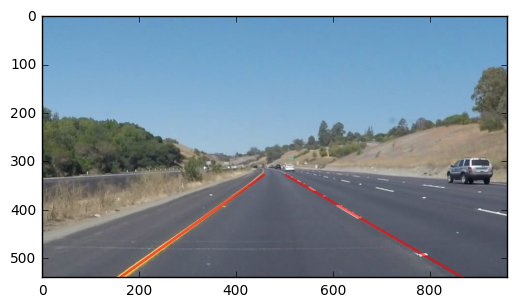

In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
  
ld = RoadLinesDetector()
image_filename = 'test_images/solidWhiteRight.jpg'
image_filename = 'test_images/solidYellowLeft.jpg'
image_filename = 'test_images/solidYellowCurve.jpg'
image = ld.processImage(image_filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)

The RoadLinesDetector() class also implements a function that can iterate over a given list of images. In this case a standalone OpenCV imshow() windows pop up. To show a next image press any key while the GUI focus is on one of the shown windows.

In [6]:
import os 

path = "test_images/"
images =  os.listdir(path)
ld = RoadLinesDetector()
ld.processImages(images, path)

[0] yellow_line_left_2.png
[1] solidYellowCurve.jpg
[2] yellow_line_left_1.png
[3] yellow_line_left_4.png
[4] whiteCarLaneSwitch.jpg
[5] solidWhiteRight.jpg
[6] solidYellowLeft.jpg
[7] solidYellowCurve2.jpg
[8] yellow_line_left_3.png
[9] solidWhiteCurve.jpg
[0] yellow_line_left_2.png
[1] solidYellowCurve.jpg


## Test on Videos

As with the still images test, first find out the available video files and then pass their names to the processVideo() function as seen in the code bellow.

In [10]:
import os

video = "solidYellowLeft.mp4"
#video = "solidWhiteRight.mp4"
video = "challenge.mp4"

path, ext = os.path.splitext(video)
white_output = path + '_annotated' + ext
        
ld = RoadLinesDetector()
ld.processVideo(video, white_output, 1)

Video file:  challenge.mp4
width:  1280
height:  720
fps:  25.0
Frame: 243   fps (processing): 45
Done


In [11]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Conclusion

While the performance of this road lines detection algorithm is satisfactory, especially given the code simplicity, there are several obvious issues to be aware of. As mentioned before the algorithm was fine tuned on a small testing sample sent only, thus it's very likely it wouldn't generalize well. The road lines are localized in image segments manually determined by visual inspection and hardcoded. The consequence is that for different camera intrinsic and extrinsic parameters this code would not work well since these segments wouldn't not be aligned with the road lines projection to the image frame. From the same reason roads with very tight turns or up/down hills areas may not work well since the lines projection mask segments will not correctly cover the full extent of the lines. The algorithm fits lines through the road marking in the close proximity of the car thus it's assumed the road lines are straight in these areas which is not the case in places with tight turns such as in urban environment. Further on there would be a snap-on delay during lane change. The algorithm uses the last known line position in case of line missing which will result in false positives during the line change. 

Recommended improvements would be:

- Use calibrated cameras with know extrinsics to automatically calculate the road line projection mask

- Localize the lines in bird's-eye view. In this case it would be easier to fit curves instead of lines as well as to perform geometrical verification of the right and left lines relatively to each other. The bird's-eye view can be easily obtained by inverse perspective mapping by calculating homography between the road and image planes.

- Use edge detection and line/curve fitting rather than line fitting to thresholded images. This would improve resiliency under variable image exposure, however it would require more careful image preprocessing (e.g. threshodling followed by skeletonization), line detection (e.g. Hough transform) and line filtering (e.g. model fitting with RANSAC) The line detection is very sensitive to the quality of the detected edges which is especially difficult to ensure in cases where the road marking is of a low quality or obscured by shadows or overexposed by sunshine. In these case the line detector doesn't find lines for that particular segment or the found line segments have solve very different from the slope of the actual road line.

- Apply RANSAC to the line fitting through the detected blobs. In this case the pior line would have to be added to the point set with added noise rather than as a straight line as is the case in this implementation. The RANSAC would help to eliminate outliers that are necessary present in small, noisy blobs thresholded along with the true road line blobs. However by adding the prior line points without any distortion the estimated line found by RANSAC would be heavily weighted towards the prior line being an ideal line.

- Currently the prior line is being added to the current line blobs as detected in the previous image. In the extreme case of missing road line marker the prior line keeps substituting the missing line infinitely which is clearly wrong. There is a need to decay the weight with which the prior line participates on the current frame line detection. This can be done quite easily by reducing the number of 2D points the prior line is represented in the total points set for the line fitting as a function of the number of consecutive video frames in which the number of inliers after the line fitting came from the prior line rather than for points from the line blobs.
